In [1]:
require(rtracklayer)
require(GenomicFormatExamples)
library(Seurat)
library(Signac)
library(ggplot2)
library(ggthemes)

Loading required package: rtracklayer

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


L

In [2]:
peaks.nano.path   <- '/data/proj/GCB_MB/bcd_CT/single-cell/results2/results/precision_recall/nanoCT/peaks/macs2_0.01/H3K27me3_peaks.broadPeak'
peaks.scCT.path   <- '/data/proj/GCB_MB/bcd_CT/single-cell/results2/results/precision_recall/scCT/peaks/macs2_0.01/H3K27me3_peaks.broadPeak'


In [3]:
extraCols_broadPeak <- c(signalValue = "numeric", pValue = "numeric",
                          qValue = "numeric")
peaks.nano <- import.bed(con = peaks.nano.path, extraCols = extraCols_broadPeak)
peaks.scCT <- import.bed(con = peaks.scCT.path, extraCols = extraCols_broadPeak)

In [4]:
peaks.nano.top <- head(peaks.nano[order(peaks.nano$qValue,decreasing=TRUE)],20000)
peaks.scCT.top <- head(peaks.scCT[order(peaks.scCT$qValue,decreasing=TRUE)],20000)

In [5]:
peak.set <- sort(c(peaks.nano,peaks.scCT))
peak.set <- reduce(peak.set)

In [6]:
nano.seurat <- readRDS(file='/data/proj/GCB_MB/bcd_CT/single-cell/results2/results/multimodal_data/single_modality/H3K27me3/seurat/peaks/Seurat_object_clustered_renamed.Rds')
scCT.seurat <- readRDS(file='/data/proj/GCB_MB/bcd_CT/single-cell/results/nbiotech_data/data/seurat/H3K27me3_seurat_object.Rds')

In [7]:
nano.fragments.path <- '/data/proj/GCB_MB/bcd_CT/single-cell/results2/results/multimodal_data/single_modality/H3K27me3/fragments/fragments.tsv.gz'
scCT.fragments.path <- '/data/proj/GCB_MB/bcd_CT/single-cell/results2/results/nbiotech_data/data/fragments/H3K27me3_fragments.tsv.gz'

nano.fragments <- CreateFragmentObject(path = nano.fragments.path,cells = Cells(nano.seurat),validate.fragments = TRUE)
scCT.fragments <- CreateFragmentObject(path = scCT.fragments.path,cells = Cells(scCT.seurat),validate.fragments = TRUE)

Computing hash

Computing hash



In [8]:
nano.matrix <- FeatureMatrix(fragments = nano.fragments,features = peak.set, cells = Cells(nano.seurat))
scCT.matrix <- FeatureMatrix(fragments = scCT.fragments,features = peak.set, cells = Cells(scCT.seurat))

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



In [9]:
nano.seurat[['peaks_frip_comp']] <- CreateAssayObject(counts = nano.matrix)
scCT.seurat[['peaks_frip_comp']] <- CreateAssayObject(counts = scCT.matrix)

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks_frip_comp_ to peaksfripcomp_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks_frip_comp_ to peaksfripcomp_”


In [10]:
DefaultAssay(nano.seurat) <- 'peaks_frip_comp'
DefaultAssay(scCT.seurat) <- 'peaks_frip_comp'

In [11]:
nano.FRIP <- Matrix::colSums(nano.seurat[['peaks_frip_comp']]@counts)/10^nano.seurat$logUMI
scCT.FRIP <- Matrix::colSums(scCT.seurat[['peaks_frip_comp']]@counts)/10^scCT.seurat$logUMI

In [12]:
head(scCT.seurat$sample)

H3K27me3_N1_AAACGAAAGATGCGCA-1 H3K27me3_N1_AAACGAAAGGCGTAGT-1 
                 "H3K27me3_N1"                  "H3K27me3_N1" 
H3K27me3_N1_AAACGAACATGGCCTG-1 H3K27me3_N1_AAACGAAGTGCGTCCA-1 
                 "H3K27me3_N1"                  "H3K27me3_N1" 
H3K27me3_N1_AAACGAAGTTGGCGAA-1 H3K27me3_N1_AAACTCGAGAGCTACG-1 
                 "H3K27me3_N1"                  "H3K27me3_N1"

In [13]:
nano.FRIP.df <- data.frame('FRIP' = nano.FRIP, 'method' = 'nanoCT','replicate' = nano.seurat$sample)
scCT.FRIP.df <- data.frame('FRIP' = scCT.FRIP, 'method' = 'scCT','replicate' = scCT.seurat$sample)

In [14]:
FRIP.df <- rbind(nano.FRIP.df, scCT.FRIP.df)

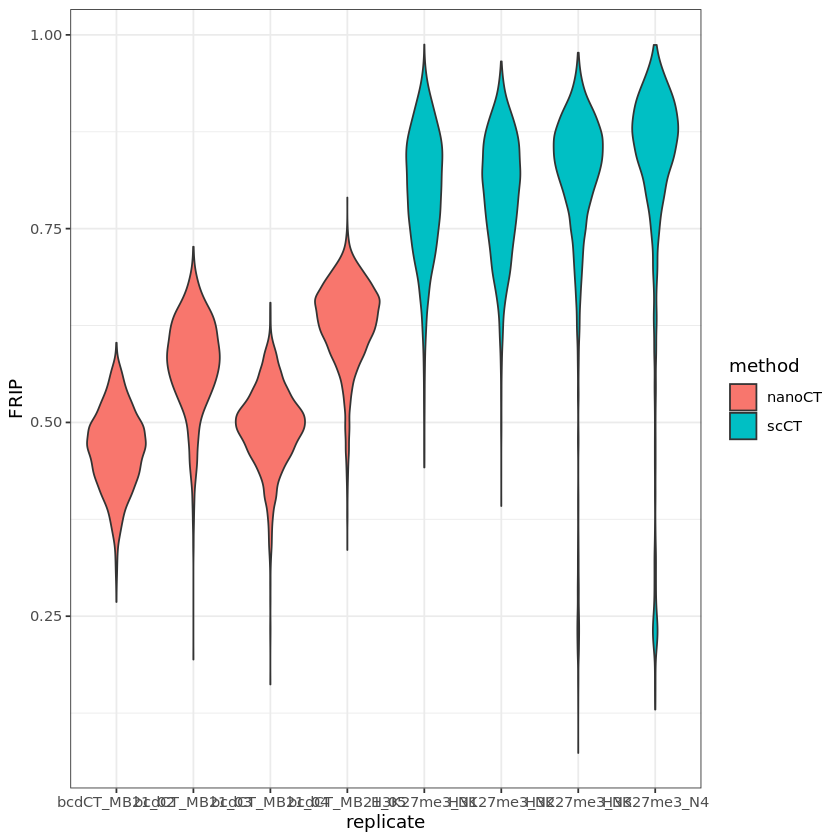

In [15]:
ggplot(data=FRIP.df) + geom_violin(aes(x=replicate,y=FRIP, fill=method)) + theme_bw()

In [16]:
aggregate(FRIP.df$FRIP,by=list(FRIP.df$replicate), FUN=median)

Group.1,x
<chr>,<dbl>
bcdCT_MB21_02,0.4678962
bcdCT_MB21_03,0.5826208
bcdCT_MB21_04,0.4964363
bcdCT_MB21_05,0.6368187
H3K27me3_N1,0.8030021
H3K27me3_N2,0.8026253
H3K27me3_N3,0.8358974
H3K27me3_N4,0.8605514


In [17]:
nano.seurat

An object of class Seurat 
106396 features across 12763 samples within 3 assays 
Active assay: peaks_frip_comp (36219 features, 0 variable features)
 2 other assays present: peaks, GA
 2 dimensional reductions calculated: lsi, umap

In [20]:
nanoCT <- readRDS(file=

ERROR: Error in FetchData.Seurat(object = object, vars = features.keyed, cells = unique(x = unlist(x = cells)), : None of the requested variables were found (10 out of 30 shown): chr2-74643875-74764956, chr15-102903890-102995145, chr6-52147253-52211502, chr15-102999276-103044377, chr8-57307313-57355119, chr11-96250376-96298651, chr6-52218165-52254361, chr13-40698123-40745765, chr14-63231769-63273248, chr11-96321108-96378708
